<h1 style="color:rgb(81,183,206);font-size:2.5em;">Skillconnect - Week 2 - Advanced Challenge 2</h1>

**Use popular pretrained architectures for transfer learning and show comparison of results**

# Getting the data

In [2]:
import kaggle
from pathlib import Path

In [3]:
data = Path("./data")
if not data.exists():
    data.mkdir()
    kaggle.api.authenticate()
    kaggle.api.dataset_download_files("tongpython/cat-and-dog",path=data,quiet=False,unzip=True,force=False)

# Readying the data
- Creating train and test dataloaders.
- Train dataset will have ColorJitter applied to it.

In [144]:
import time
import numpy as np
np.random.seed(34)

from torch.utils.data import DataLoader, Subset
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToPILImage, ToTensor, ColorJitter, CenterCrop, Normalize, Resize, Compose

In [140]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
def get_mean_std(ds):
    """
    Gets mean and std of an ImageFolder (instance) dataset.
    """
    means = []
    stds = []
    for d in ds:
        means.append(d[0].mean(axis=(2,1)).numpy())
        stds.append(d[0].std(axis=(2,1)).numpy())
    mean = np.array(means).mean(axis=0)
    std = np.array(stds).mean(axis=0)
    return mean, std

class CatDogDataset(ImageFolder):
    """
    Custom dataset designed so that images can be viewed.
    """
    def __init__(self,root, mean, std,**kwargs):
        self.class_labels = ['cat','dog']
        self.topil = ToPILImage()
        self.norm = Normalize(mean, std)
        super().__init__(root, **kwargs)
    
    def image(self,idx):
        img, l = super().__getitem__(idx)
        return self.topil(img),self.class_labels[l]
    
    def __getitem__(self,idx):
        item = super().__getitem__(idx)
        return self.norm(item[0]),item[1]

Find mean and std of off the train dataset

In [6]:
# mean =  np.array([0.48826352,0.45509255,0.4174077])
# std =   np.array([0.22981022,0.22478424,0.22537524])

# Takes time to run cause > 8000 images, also there may be a better way to do this
temp_ds = ImageFolder(data/'training_set/training_set',transform=ToTensor())
mean, std = get_mean_std(temp_ds) 
print("mean: ",*mean)
print("std:  ",*std)

mean:  0.48826352 0.45509255 0.4174077
std:   0.22981022 0.22478424 0.22537524


In [7]:
training_transforms = Compose([
    ColorJitter(0.3,0.3,0.3),
    Resize(256),
    CenterCrop(224),
    ToTensor()
])
testing_transforms = Compose([
    Resize(256),
    CenterCrop(224),
    ToTensor()
])

ds_train = CatDogDataset(data/'training_set/training_set',mean ,std ,transform=training_transforms)
ds_test_all = CatDogDataset(data/'test_set/test_set',mean ,std ,transform=testing_transforms)

- Generating indices for the subset sampler to divide test set into test and valid.  
- Selecting test set here because test set size is 25% of train set.  
- Valid set is 0.2 of test set (404 samples, striated)

In [10]:
valid_percent = 0.2
valid_size = int(0.2 * len(ds_test_all))
cat_idx = np.random.permutation(np.arange(0,1011))[:int(valid_size/2)]
dog_idx = np.random.permutation(np.arange(1012,2023))[:int(valid_size/2)]

valid_idx = np.concatenate([cat_idx,dog_idx])
test_idx = np.array(list(filter(lambda x: x not in valid_idx, np.arange(len(ds_test_all)))))

ds_test = Subset(ds_test_all, test_idx)
ds_valid = Subset(ds_test_all, valid_idx)

Create Dataloaders for all datasets.

In [124]:
dl_train,dl_valid,dl_test = [DataLoader(ds,64,shuffle=True) for ds in [ds_train, ds_valid, ds_test]]
sets = ['tr','va','te']
TR,VA,TE = sets

for name,dl in zip(['train','valid','test'],[dl_train,dl_valid,dl_test]):
    print(name.ljust(5),len(dl.dataset))
    
dl = {s[0]:s[1] for s in zip(sets,[dl_train,dl_valid,dl_test])}

train 8005
valid 404
test  1619


Create small datasets, loaders for testing hyper params

In [207]:
sz = 10
micro_tr = np.concatenate([cat_idx[:sz*2],dog_idx[:sz*2]+4000])
micro_va = np.concatenate([cat_idx[:sz],dog_idx[:sz]])

dl_micro = {
    TR: DataLoader(Subset(ds_train,micro_tr),5,shuffle=True),
    VA: DataLoader(Subset(ds_test_all,micro_va),5,shuffle=True)
}

len(dl_micro[TR].dataset), len(dl_micro[VA].dataset)

(40, 20)

# Checking some test samples

In [12]:
import matplotlib.pyplot as plt

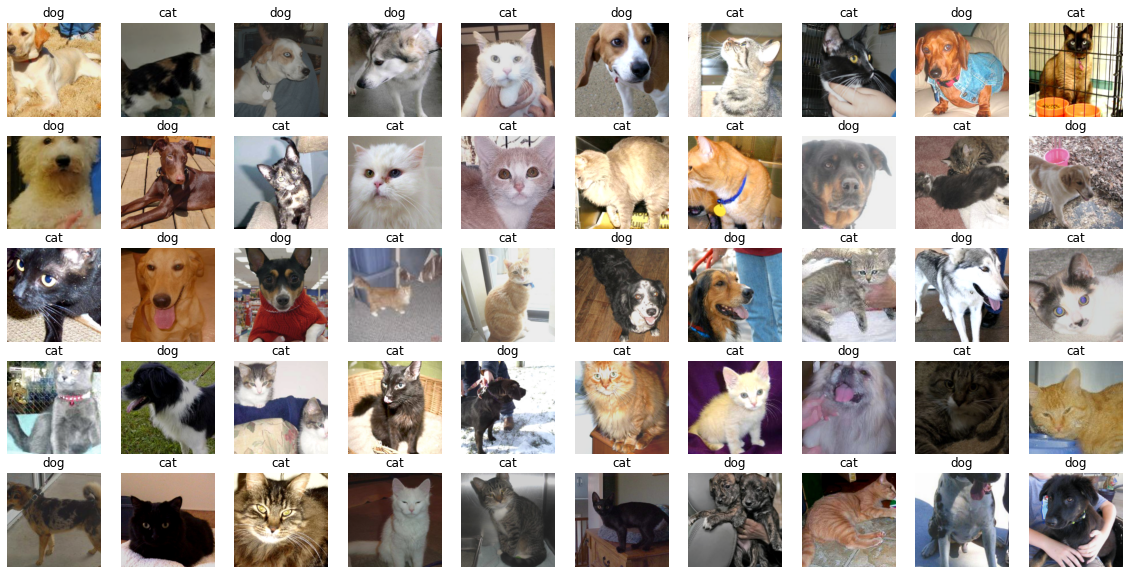

In [13]:
r,c = 5,10
rand_idx = np.random.randint(0,len(ds_train),r*c)

plt.figure(figsize=(20,10))
for i,idx in enumerate(rand_idx):
    img, lbl = ds_train.image(idx)
    plt.subplot(r,c,i+1)
    plt.title(lbl)
    plt.axis('off')
    plt.imshow(img)

___

# Getting Inception Resnet v2
There is no pytorch implementation for this model so getting it from [Cadene/pretrained-models.pytorch](https://github.com/Cadene/pretrained-models.pytorch/blob/master/pretrainedmodels/models/inceptionresnetv2.py)

In [24]:
import requests
import torch
import torch.nn as nn

In [15]:
irv2_url = "https://raw.githubusercontent.com/Cadene/pretrained-models.pytorch/master/pretrainedmodels/models/inceptionresnetv2.py"
irv2_path = data/"inceptionresnetv2.py"
if not irv2_path.exists():
    content = requests.get(irv2_url).content
    irv2_path.open('w').write(content.decode('utf-8'))

# Loading the models


In [16]:
from torchvision import models
from data.inceptionresnetv2 import inceptionresnetv2

In [175]:
pretrained = False

resnet_50 = models.resnet50(pretrained)
resnext50 = models.resnext50_32x4d(pretrained)
wresnet50 = models.wide_resnet50_2(pretrained)
incresnv2 = inceptionresnetv2()

# The model definition has kernel_size set as 8 which may be a typo
# ∵ the previous layer has W and H of 5.
incresnv2.avgpool_1a = nn.AvgPool2d(kernel_size=(5, 5),
                                    count_include_pad=False)

try:
    del old_fc
except:
    pass

pt_resnets = [resnet_50, resnext50, wresnet50]
pt_resnets_names = ['resnet50','resnext50','wresnet50']

# Readying models for Transfer Learning

In [176]:
"""
Altering the pytorch resnets as all have the same last
fully connected layer labelling
"""
# Prevent all layers from training.
def freeze_all_layers(net):
    for params in net.parameters():
        params.requires_grad = False

def replace_fc(nets, old_fc):
    out_features = 2
    for net in nets:
        old_fc.append(net.fc)
        in_features = net.fc.in_features
        fc = nn.Sequential(
            nn.Linear(in_features,out_features),
            nn.Softmax(dim=1)
        )
        net.fc = fc
        for params in net.fc.parameters():
            params.requires_grad = True
    
for net in pt_resnets:
    freeze_all_layers(net)
    
try:
    if len(old_fc) == 0:
        replace_fc(pt_resnets, old_fc)
    else:
        print('already replaced')
except:
    old_fc = []
    replace_fc(pt_resnets, old_fc)


In [177]:
"""
Altering the inception resnet v2
"""
freeze_all_layers(incresnv2)

in_features = incresnv2.last_linear.in_features
out_features = 2
incresnv2.last_linear = nn.Sequential(
            nn.Linear(in_features,out_features),
            nn.Softmax(dim=1)
        )

for params in incresnv2.last_linear.parameters():
    params.requires_grad == True

# Helper Functions

## Fit Functions

In [184]:
# A simple fit function without any logging
def simple_fit(model,dl,optim,loss_func,epoch=10):
    model = model.to(device)
    losses = []
    for e in range(epoch):
        r_loss = 0
        for X,y in dl:
            bs = y.size(0)
            X = X.to(device)
            y = y.to(device)

            optim.zero_grad()
            y_ = model(X)
            loss = loss_func(y_,y)
            loss.backward()
            optim.step()
            r_loss += loss.item() * bs
        losses.append(r_loss/len(dl.dataset))
    return losses

# A verbose fit function with logging.
def fit(model, optim, sched, loss_func, dl, epochs=1, is_test=False):
    model = model.to(device)

    # Test batch multipliers
    tb_t,tb_v = 6,2

    # To switch between training and validation
    phases = [TR, VA]

    # Measure total time
    tot_time = time.time()

    # Record metrics
    losses = {TR:[], VA:[]}
    accuracies = {TR:[], VA:[]}

    # Dataset sizes for accu and loss calcualtions
    sizes = {ph: len(dl[ph].dataset) for ph in phases}
    if is_test:
        sizes[TR] = tb_t * dl[TR].batch_size
        sizes[VA] = tb_v * dl[VA].batch_size
    
    # Init markers
    least_loss = float('inf')
    best_accu = 0
    best_model = deepcopy(model.state_dict())
    
    for e in range(epochs):
        # Measure the epoch time (train + valid)
        epo_time = time.time()

        # Print epoch counter
        epoch_st = f"[{e+1}/{epochs}]".rjust(len(str(epochs))*2+3)
        print(f"{epoch_st} | ",end="")
        if is_test:
            print("[", end="")
        
        for phase in phases:
            # Running metrics, caluclate as they come in
            running_loss = 0
            running_corr = 0

            # bool checker used ahead for updating markers and optimizer step
            is_tr = phase == TR

            # Iterate over training or validation batch
            for b_num,batch in enumerate(dl[phase]):

                # Limit batches if testing fit function
                if is_test:
                    if is_tr:
                        print(b_num,end=" ")
                        if b_num == tb_t:
                            break
                    elif not is_tr and b_num == tb_v:
                        break
                    else:
                        pass

                # Get data and batch size
                X,y = batch
                bs = y.size(0)
                
                # Shift data to device (when GPU)
                X = X.to(device)
                y = y.to(device)
                    
                # Reset gradients to zero
                optim.zero_grad()
                
                # Sets model.eval or model.train depending on bool
                with torch.set_grad_enabled(is_tr):

                    # Forward pass 
                    y_pred = model(X)

                    # Calculate loss using loss_function 
                    loss = loss_func(y_pred,y)

                    # Update weights only if trianing phase
                    if is_tr:
                        loss.backward()
                        optim.step()
                        
                    # Update lr if validation loss don't change none
                    if not is_tr:
                        sched.step()
                
                # Deaverage the loss and get correct predictions
                batch_loss = loss.item() * bs
                batch_corr = (y_pred.argmax(dim=1) == y).sum().item()
                # Add to running metrics
                running_loss += batch_loss
                running_corr += batch_corr
            if is_test and is_tr:
                print('] | ',end="")
                

            # Calculate epochal loss and accu
            epo_loss = running_loss / sizes[phase]
            epo_accu = running_corr / sizes[phase]
            
            # Print epochal metrics
            print(f"{phase} :: loss: {epo_loss:0.4f} accu: {epo_accu:0.4f} | ", end="")
            
            # Store metrics
            losses[phase].append(epo_loss)
            accuracies[phase].append(epo_accu)
            
            # Update markers if not training
            if not is_tr:
                if epo_accu > best_accu:
                    best_accu = epo_accu
            
                if epo_loss < least_loss:
                    least_loss = epo_loss
                    best_model = deepcopy(model.state_dict())
            
        # Print time taken by epoch
        end_time = np.round(time.time() - epo_time,3)
        s,ms = str(end_time).split('.')
        print(f"time {s} s {ms} ms")

    # Restore "best" model, print total time and metrics.
    model.load_state_dict(best_model)
    end_time = np.round(time.time() - tot_time,3)
    s,ms = str(end_time).split('.')
    print(f"best accuracy: {best_accu:0.4f} least loss: {least_loss:0.4f}")
    print(f"time {int(s)//60} m {int(s)%60} s {ms} ms")

    return losses, accuracies

## Metric Helpers

In [224]:
# Function to check the accuracy and loss of a model.
def check_accu(model, dl_test, verbose=True, loss_func=nn.CrossEntropyLoss()):
    
    model = model.to(device)
    model.eval()
    
    bs = dl_test.batch_size
    size = len(dl_test.dataset)
    batch_count = size//bs
    
    corrects = 0
    losses = 0
    percent = 0
    if verbose:
        print(f"batches ({batch_count}): ",end="\n\t")
    for i,batch in enumerate(dl_test):
        with torch.no_grad():
            X,y = batch
            if verbose:
                print(str(i).rjust(len(str(batch_count))+1),end="")
                if ((i+1) % 25) == 0:
                    print(end="\n\t")

            b = len(y)
            X = X.to(device)
            y = y.to(device)
            y_ = model(X)

            losses += loss_func(y_,y).item() * b
            corrects += (y_.argmax(dim=1)==y).sum().item()
    loss, accu = losses/size, corrects/size
    if verbose:
        print(f"\nloss: {loss:0.4f} accuracy: {accu:0.4f}")
    return loss, accu


# Check for learning rates
def net_tester(name,model,dl,test_epochs,lr_list):
    losses_list = []
    metric_list = []
    for lr in lr_list:
        loss_func = torch.nn.CrossEntropyLoss()
        if name == 'inceptionresnetv2':
            optim = torch.optim.Adam(model.last_linear.parameters())
        else:
            optim = torch.optim.Adam(model.fc.parameters())
        # Obtain the metrics
        losses_ = simple_fit(model,dl,optim,loss_func,epoch=test_epochs)
        loss_, accu_ = check_accu(model,dl,False)

        # Store the metrics
        losses_list.append(losses_)
        metric_list.append((loss_,accu_))

        # Disply the metrics
        print(f"lr: {lr}\tloss: {loss_}   accu: {accu_}")
        plt.figure(figsize=(10,5))
        plt.grid(True)
        plt.plot(np.arange(len(losses_)),losses_)
        plt.show()
    return losses_list, metric_list

___

# Test for learning rate

In [178]:
from copy import deepcopy

In [216]:
all_nets = [*pt_resnets, incresnv2]
all_nets_names = [*pt_resnets_names, 'inceptionresnetv2']
all_nets_sd = []
for net in all_nets:
    all_nets_sd.append(deepcopy(net.state_dict()))
    
nets = {all_nets_names[i]:all_nets[i] for i in range(len(all_nets))}

In [182]:
def check_time_single_epoch_time(dl):
    for name in nets:
        net = nets[name] 
        loss_func = nn.CrossEntropyLoss()
        if name == 'inceptionresnetv2':
            optim = torch.optim.Adam(net.last_linear.parameters())
        else:
            optim = torch.optim.Adam(net.fc.parameters())
        sched = torch.optim.lr_scheduler.StepLR(optim,10,0.5)
        
        print(f"NETWORK: {name}")
        _ = fit(net, optim, sched, loss_func, dl, is_test=True)    
        print()

In [210]:
check_time_single_epoch_time(dl_micro)

NETWORK: resnet50
[1/1] | [0 1 2 3 4 5 6 ] | tr :: loss: 0.8561 accu: 0.3667 | va :: loss: 0.9091 accu: 0.4000 | time 9 s 799 ms
best accuracy: 0.4000 least loss: 0.9091
time 0 m 9 s 914 ms

NETWORK: resnext50
[1/1] | [0 1 2 3 4 5 6 ] | tr :: loss: 0.8148 accu: 0.5000 | va :: loss: 0.9133 accu: 0.4000 | time 11 s 502 ms
best accuracy: 0.4000 least loss: 0.9133
time 0 m 11 s 972 ms

NETWORK: wresnet50
[1/1] | [0 1 2 3 4 5 6 ] | tr :: loss: 0.8041 accu: 0.5667 | va :: loss: 0.7133 accu: 0.6000 | time 17 s 52 ms
best accuracy: 0.6000 least loss: 0.7133
time 0 m 18 s 851 ms

NETWORK: inceptionresnetv2
[1/1] | [0 1 2 3 4 5 6 ] | tr :: loss: 0.7139 accu: 0.4667 | va :: loss: 0.6583 accu: 0.4000 | time 12 s 689 ms
best accuracy: 0.4000 least loss: 0.6583
time 0 m 14 s 037 ms



NETWORK: resnet50
lr: 0.001	loss: 0.7502308413386345   accu: 0.5


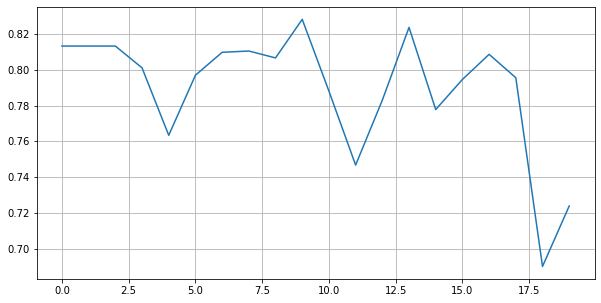

lr: 0.0005	loss: 0.813255712389946   accu: 0.5


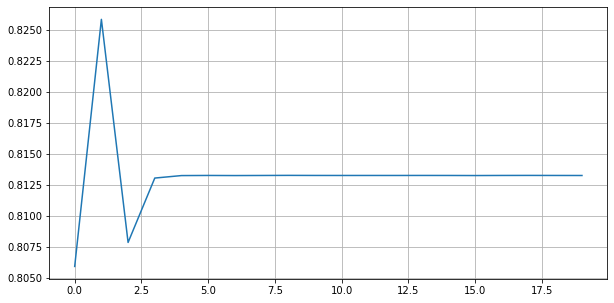

lr: 0.001	loss: 0.8132616356015205   accu: 0.5


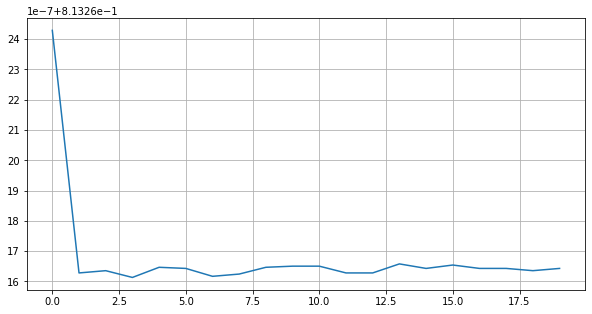

5.0 m  55.13310694694519 s  

NETWORK: resnext50
lr: 0.001	loss: 0.8132616281509399   accu: 0.5


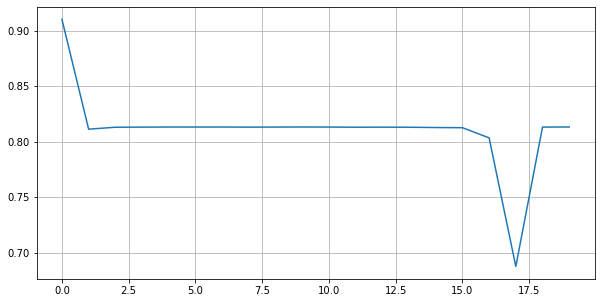

lr: 0.0005	loss: 0.8132616356015205   accu: 0.5


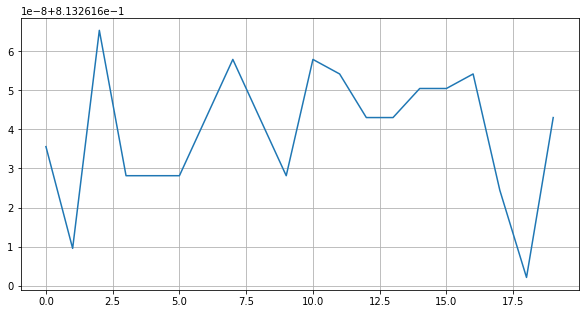

lr: 0.001	loss: 0.8132616505026817   accu: 0.5


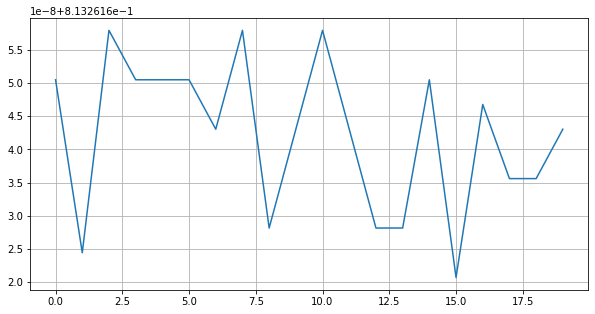

7.0 m  59.627289056777954 s  

NETWORK: wresnet50
lr: 0.001	loss: 0.8132574185729027   accu: 0.5


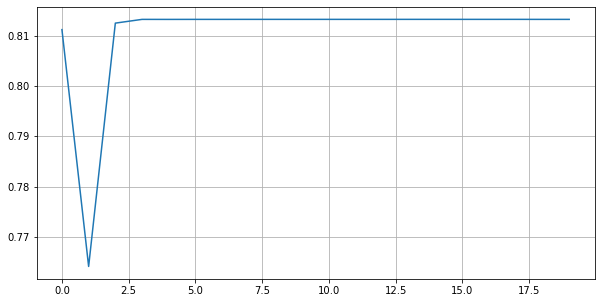

lr: 0.0005	loss: 0.8132610619068146   accu: 0.5


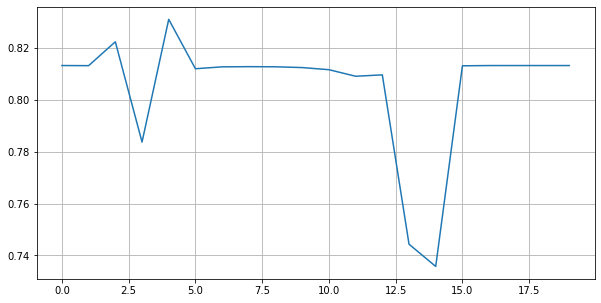

lr: 0.001	loss: 0.8132612630724907   accu: 0.5


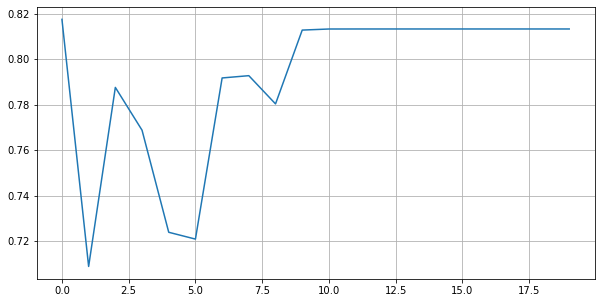

14.0 m  18.286998987197876 s  

NETWORK: inceptionresnetv2
lr: 0.001	loss: 0.3867621123790741   accu: 0.975


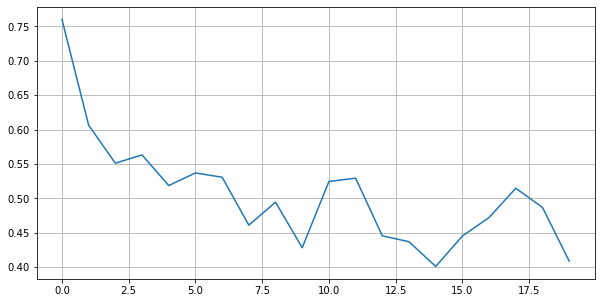

lr: 0.0005	loss: 0.34174801781773567   accu: 0.975


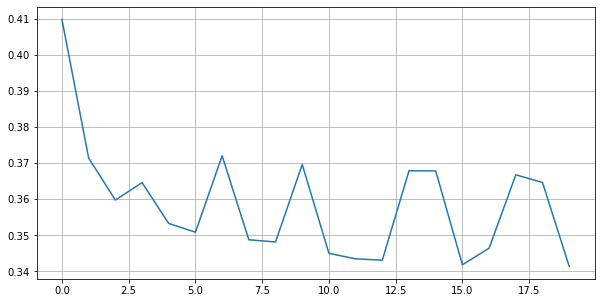

KeyboardInterrupt: 

In [225]:
learning_rates = [0.001,0.0005,0.0001]
for name in nets:
    print(f"NETWORK: {name}")
    t1 = time.time()
    net_tester(name, nets[name],dl_micro[TR],20, learning_rates)
    time_taken = time.time() - t1
    print(time_taken//60,'m ',time_taken % 60,'s ','\n')

___

# Transfer Learning

In [231]:
import pandas as pd
from torchsummary import summary

In [229]:
def transfer_learn(model,params,lr,dl):
    optim = torch.optim.Adam(params,lr,weight_decay=1e-4)
    sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optim,factor=0.5,patience=5,threshold=5e-5)
    loss_function = nn.CrossEntropyLoss()
    def prep(epochs):
         return fit(model,optim,sched,loss_function,dl,epochs)
    return prep

## Resnet 50

In [228]:
summary(nets['resnet50'],input_size=(3,224,224),device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
tl_r50 = transfer_learn(nets['resnet50'],nets['resnet50'].fc.parameters(),,dl)

In [ ]:
epochs = 
metrics_r50 = tl_r50(epochs)
pd.DataFrame(metrics_r50).plot()
plt.figure(figsize=(10,5))
plt.grid()
plt.show()

In [ ]:
check_accu(nets['resnet50'],dl[TE])

## ResNext 50

In [234]:
summary(nets['resnext50'],input_size=(3,224,224),device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5          [-1, 128, 56, 56]           8,192
       BatchNorm2d-6          [-1, 128, 56, 56]             256
              ReLU-7          [-1, 128, 56, 56]               0
            Conv2d-8          [-1, 128, 56, 56]           4,608
       BatchNorm2d-9          [-1, 128, 56, 56]             256
             ReLU-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          32,768
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
tl_rnx50 = transfer_learn(nets['resnext50'],nets['resnext50'].fc.parameters(),,dl)

In [ ]:
epochs = 
metrics_rnx50 = tl_rnx50(epochs)
pd.DataFrame(metrics_rnx50).plot()
plt.figure(figsize=(10,5))
plt.grid()
plt.show()

In [ ]:
check_accu(nets['resnext50'],dl[TE])

## Wide Resnet 50

In [237]:
summary(nets['wresnet50'],input_size=(3,224,224),device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5          [-1, 128, 56, 56]           8,192
       BatchNorm2d-6          [-1, 128, 56, 56]             256
              ReLU-7          [-1, 128, 56, 56]               0
            Conv2d-8          [-1, 128, 56, 56]         147,456
       BatchNorm2d-9          [-1, 128, 56, 56]             256
             ReLU-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          32,768
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
tl_wr50 = transfer_learn(nets['wresnet50'],nets['wresnet50'].fc.parameters(),,dl)

In [ ]:
epochs = 
metrics_wr50 = tl_wr50(epochs)
pd.DataFrame(metrics_wr50).plot()
plt.figure(figsize=(10,5))
plt.grid()
plt.show()

In [ ]:
check_accu(nets['wresnet50'],dl[TE],)

## Inception Resnet v2

In [236]:
summary(nets['inceptionresnetv2'],input_size=(3,224,224),device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 111, 111]             864
       BatchNorm2d-2         [-1, 32, 111, 111]              64
              ReLU-3         [-1, 32, 111, 111]               0
       BasicConv2d-4         [-1, 32, 111, 111]               0
            Conv2d-5         [-1, 32, 109, 109]           9,216
       BatchNorm2d-6         [-1, 32, 109, 109]              64
              ReLU-7         [-1, 32, 109, 109]               0
       BasicConv2d-8         [-1, 32, 109, 109]               0
            Conv2d-9         [-1, 64, 109, 109]          18,432
      BatchNorm2d-10         [-1, 64, 109, 109]             128
             ReLU-11         [-1, 64, 109, 109]               0
      BasicConv2d-12         [-1, 64, 109, 109]               0
        MaxPool2d-13           [-1, 64, 54, 54]               0
           Conv2d-14           [-1, 80,

In [ ]:
tl_irv2 = transfer_learn(nets['inceptionresnetv2'],nets['inceptionresnetv2'].fc.parameters(),,dl)

In [ ]:
epochs = 
metrics_irv2 = tl_irv2(epochs)
pd.DataFrame(metrics_irv2).plot()
plt.figure(figsize=(10,5))
plt.grid()
plt.show()

In [ ]:
check_accu(nets['inceptionresnetv2'],dl[TE],)